# All settings will be given to the channel 1 output, in the DC Amp out configuration

In [70]:
%matplotlib inline 

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import pyvisa as visa
from matplotlib import animation
from matplotlib.animation import FuncAnimation
#Importing the functions from the module and the pulses dictionaries
from Sweeping import *
from Dictionaries import *

# Visa interface for the M8190A instrument:

In [2]:
rm = visa.ResourceManager();
M8190A = rm.open_resource('TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR')
M8190A.read_termination = '\n'
M8190A.write_termination = '\n'
M8190A.query('*IDN?')

'Agilent Technologies,M8190A,MY57701776,5.6.0.0-2'

In [3]:
print(rm.list_resources())

('TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR',)


## Instrument Initialitaion and Settings

In [4]:
M8190A.write('INST:COUP:STAT 0') #Decoupling the channels
M8190A.write('OUTP1:ROUT DC') #setting the output to DC 
M8190A.write('OUTP1 ON') #activating the output "Amp Out"
M8190A.write('DC1:VOLT:AMPL {volt}'.format(volt = AWG_S1['Amplitude']/1000)) #Setting voltage amplitude to 300mlV
M8190A.write('FREQ:RAST {sr}'.format(sr = AWG_S1['Clock Sample Frecuency']))  #Setting the sample rate to 7.2Ghz

20

In [12]:
M8190A.write('FREQ:RAST {sr}'.format(sr = AWG_S2['Clock Sample Frecuency']))  #Setting the sample rate to 7.2Ghz

21

# Quering Instrument Settings

In [24]:
print(M8190A)

TCPIPInstrument at TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR


In [136]:
M8190A.write('FREQ:RAST {sr}'.format(sr = AWG_S2['Clock Sample Frecuency']))

21

In [7]:
M8190A.query('FREQ:RAST?') 

'1.25000000000000E+08'

In [26]:
M8190A.query(':DC:VOLT:AMPL?') 

'3.00000000000000E-01'

# Testing

In [19]:
#Pulse Sequence1

start = time.time()

pl, ti = Sweep(Pulses_List,10,0,15,108000)

pullist = pl/AWG_S1['Amplitude']
DFA = CSV_PD(pullist,'A','SegmentA_108000')

end = time.time()

print(end - start)

0.7266342639923096


In [20]:
DFA

,Y1,SyncMarker1,SampleMarker1
0,0.000000,1,1
1,0.666667,1,1
2,0.666667,1,1
3,0.666667,1,1
4,0.666667,1,1
...,...,...,...
107995,0.000000,1,1
107996,0.000000,1,1
107997,0.000000,1,1
107998,0.000000,1,1


In [21]:
#Pulse Sequence2

start = time.time()

mpl, mti = Sweep(Pulses_List2,10,0,15,108000)
pullist2 = mpl/AWG_S1['Amplitude']
DFB = CSV_PD(pullist2,'B','SegmentB_108000')

end = time.time()

print(end - start)

0.7615032196044922


In [22]:
DFB

,Y1,SyncMarker1,SampleMarker1
0,0.000000,0,0
1,0.666667,0,0
2,0.666667,0,0
3,0.666667,0,0
4,0.666667,0,0
...,...,...,...
107995,0.000000,0,0
107996,0.000000,0,0
107997,0.000000,0,0
107998,0.000000,0,0


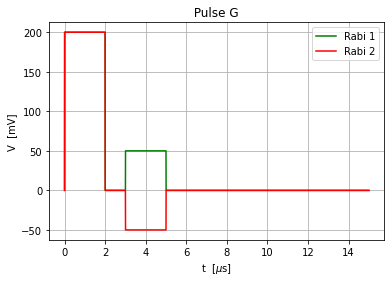

In [6]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(ti,pl,'-g',label= 'Rabi 1')
plt.plot(mti,mpl,'-r',label= 'Rabi 2')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [$\mu$s]')
ax.set_title(' Pulse G ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [7]:
Pulses_List2

[{'Name': 'Rabi',
  'Amplitude': 200,
  'Start time': 1e-10,
  'End time': 2e-10,
  'Start Duration': 2,
  'End Duration': 6,
  'Sweep time': 0,
  'Sweep Duration': 0},
 {'Name': 'Probe2',
  'Amplitude': -50,
  'Start time': 1,
  'End time': 20,
  'Start Duration': 2,
  'End Duration': 9,
  'Sweep time': 0,
  'Sweep Duration': 0}]

# Sending the Pulse information to the instrumet, TRAC subsystem

In [54]:
M8190A.write('TRAC1:DEL:ALL') #Delets the stored segments in the instrument

14

In [30]:
#Segment for Rabi1
M8190A.write('TRAC1:IQIM 3, "C:\\Users\\a.hernandez.de.la.ve\\Documents\\GitHub\\STM\\M8190\\SegmentA_108000.csv", CSV, BOTH, ON, ALEN')
M8190A.write('TRAC1:NAME 3, "Positive Pump"')

30

In [31]:
#Segment for Rabi2
M8190A.write('TRAC1:IQIM 4, "C:\\Users\\a.hernandez.de.la.ve\\Documents\\GitHub\\STM\\M8190\\SegmentB_108000.csv", CSV, BOTH, ON, ALEN')
M8190A.write('TRAC1:NAME 4, "Negative Pump"')

30

In [111]:
M8190A.query('TRAC:NAME? 2')

'"Negative Probe"'

In [34]:
M8190A.query('TRAC1:CAT?') #catalogue of the corresponding traces stored in memory

'3,108000,4,108000'

In [35]:
M8190A.write(':TRAC1:SEL 4') 
M8190A.write('INIT:IMM')

9

In [36]:
M8190A.write('ABOR')

5

# SEQUENCES

In [66]:
M8190A.write('FUNC1:MODE STS') 
M8190A.query('SEQ1:DEF:NEW? 2') #Defining the length (numbrer of table steps) of the Sequence
M8190A.query('SEQ:CAT?')

'0,2'

In [113]:
M8190A.query('SEQ1:DEF:NEW? 2')

'2'

In [65]:
M8190A.write('SEQ1:DEL:ALL')

13

In [67]:
M8190A.query('SEQ:CAT?')

'0,2'

In [81]:
#Understanding the structure of the SEQ:DATA command

#M8190A.write('[:SOURce]:SEQuence[1|2]:DATA <sequence_id>,<step>,[<value>,<value>,…|<data block>] <segment_id>, <loop_count>,<advance_mode>,<marker_enable>, <start_addr>,<end_addr>

#M8190A.query('[:SOURce]:SEQuence[1|2]:DATA? <sequence_id>,<step>,<length>')

#<advance_mode> 0: AUTO, 1: CONDitional, 2: REPeat, 3: SINGle. Specifies how the generator advances from one sequence table entry to the next one.

In [68]:
#This! Loading Segment 1 to step 0 of Sequence 0
M8190A.write('SEQ1:DATA 0,0,3,1,0,1,0,#hFFFFFFFF')

35

In [69]:
#Loading Segment 2 to step 1 of Sequence 0
M8190A.write('SEQ1:DATA 0,1,4,1,0,1,0,#hFFFFFFFF')

35

In [121]:
#The query form returns for a given sequence-id and step the segment data items (segment-id, loop-count, advance-mode, marker-enable, start-addr, end-addr).
#Getting this from the sequence generated via software

M8190A.query('SEQ1:DATA? 2,0,2')

'3,1,0,1,0,107999,4,1,0,1,0,107999'

In [33]:
M8190A.query('SYST:ERR?')

'-300,"Device-specific error;CH1: Waveform file ""C:\\Users\\a.hernandez.de.la.ve\\Documents\\GitHub\\STM\\M8190\\SegB_108000.csv"" not found."'

In [71]:
M8190A.write('STAB1:SEQ:SEL 0')

16

In [72]:
M8190A.write('INIT:IMM')

9

In [73]:
M8190A.write('ABOR')

5

# Marker Subsystem

Import the marker sample data through cvs with the following order:

" M8190A User’s Guide 287
CSV

_ Normalized values (-1.0 .. +1.0) and markers in comma delimited format. The file can contain either 1 (waveform data for channel 1), 2 (waveform data for channel 1 & 2), 3 (waveform data, sample marker, sync marker for channel 1) or 6 (waveform data, sample marker, sync marker for channel 1 and 2) columns. If the file contains data for two channels, it will be treated as IQ file._

While trying to write a sinus function throught the marker channel:

_"-300,"Device-specific error;CH1: Error in file ""Puls1.csv""(line: 1): Marker data ""-1.00E-10"" is not valid. Marker data can be either 1 or 0."'"_


In [ ]:
M8190A.write('FUNC1:MODE ARB')

In [82]:
M8190A.query('SYST:ERR?')

'-222,"Data out of range;CHANNEL 1 SAMPLE MRK OUT: SampleMarkerHiL = 500mV out of range 625mV .. 1.75V."'

In [84]:
M8190A.query('MARK:SAMP:VOLT:HIGH?')

'6.25000000000000E-01'

In [85]:
M8190A.write('MARK:SAMP:VOLT:HIGH 1 ')

23

In [57]:
M8190A.write('MARK1:SAMP:VOLT:AMPL .3')

24

In [53]:
M8190A.query('MARK1:SAMP:VOLT:AMPL?')

'3.00000000000000E-01'

In [16]:
M8190A.query('MARK1:SYNC:VOLT:AMPL?')

'5.00000000000000E-01'

# Sequence for a 100 Hz marker syncronization

## Sync clock / Sequencer Clock

The data generation consists of a Sample Memory which contains the sample data, a Sequence Memory which contains the required information for sequencing like the sequence structure or loop counter values and a Channel FPGA which combines both into a sequence controlled sample stream. These parts cannot run at sample clock rate and therefore multiple samples must be executed in parallel at a lower clock speed. **Depending on the selected direct mode, the Sync Clock, also called Sequencer Clock is the sample clock divided by 64 (high speed mode) or by 48 (high precision mode)**. When using the interpolated modes (refer to the chapter Digital Up-Conversion), one Sync Clock cycle covers 24 delivered (not interpolated) IQ sample pairs. Therefore, a sync clock cycle consists of “24*interpolation factor” DAC samples.
The DAC converts the parallel sample stream to sample clock granularity. The analog output of the DAC can either be used directly at the DIRECT OUT pin or can be routed through two different available amplifier paths.

3.1.3 Sequencer Granularity

The sequencer is running at a lower clock speed than the sample rate of the instrument.
Therefore the sequencer has to play multiple samples within one sync clock cycle.
The number of samples played within one sync clock cycle is called sequencer
granularity or segment granularity. For details, refer to the block diagram in section


## Instrument Settings:


In [95]:
M8190A.write('*RST')
M8190A.write('INST:COUP:STAT 0') #Decoupling the channels
M8190A.write('OUTP1:ROUT DC') #setting the output to DC 
M8190A.write('OUTP1 ON') #activating the output "Amp Out"
M8190A.write('DC1:VOLT:AMPL {volt}'.format(volt = AWG_S1['Amplitude']/1000)) #Setting voltage amplitude to 300mV
M8190A.write('FREQ:RAST {sr}'.format(sr = AWG_S1['Clock Sample Frecuency']))  #Setting the sample rate to 125 Mhz

20

In [6]:
M8190A.write('FREQ:RAST 7200000000')

21

In [6]:
5e-3 * 7200000000

36000000.0

## Creating the Segments with the Sweep code

In [37]:
#Pulse Sequence1
start = time.time()

pl, ti = Sweep(Pulses_List,10,0,5,36000000)
pulp_100 = pl/AWG_S1['Amplitude']
DFA3 = CSV_PD(pulp_100,'A','SegA_36000000')

end = time.time()
print(end - start)

254.39710688591003


In [38]:
DFA3

,Y1,SyncMarker1,SampleMarker1
0,0.000000,1,1
1,0.666667,1,1
2,0.666667,1,1
3,0.666667,1,1
4,0.666667,1,1
...,...,...,...
35999995,0.166667,1,1
35999996,0.166667,1,1
35999997,0.166667,1,1
35999998,0.166667,1,1


In [39]:
#Pulse Sequence2
start = time.time()

mpl, mti = Sweep(Pulses_List2,10,0,5,36000000)
puln_100 = mpl/AWG_S1['Amplitude']
DFB3 = CSV_PD(puln_100,'B','SegB_36000000')

end = time.time()
print(end - start)

254.3476071357727


In [40]:
DFB3

,Y1,SyncMarker1,SampleMarker1
0,0.000000,0,0
1,0.666667,0,0
2,0.666667,0,0
3,0.666667,0,0
4,0.666667,0,0
...,...,...,...
35999995,-0.166667,0,0
35999996,-0.166667,0,0
35999997,-0.166667,0,0
35999998,-0.166667,0,0


In [41]:
M8190A.query('SYST:ERR?')

'-300,"Device-specific error;CH1: Segment id 4 is not defined."'

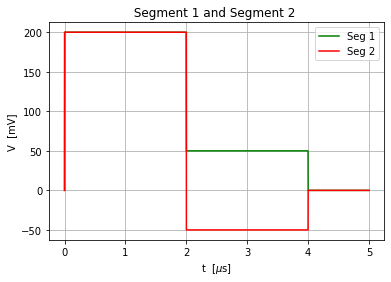

In [9]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(ti,pl,'-g',label= 'Seg 1')
plt.plot(mti,mpl,'-r',label= 'Seg 2')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [$\mu$s]')
ax.set_title(' Segment 1 and Segment 2  ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [161]:
Pulses_List

[{'Name': 'Rabi',
  'Amplitude': 200,
  'Start time': 1e-10,
  'End time': 2e-10,
  'Start Duration': 2,
  'End Duration': 6,
  'Sweep time': 0,
  'Sweep Duration': 0},
 {'Name': 'Probe1',
  'Amplitude': 50,
  'Start time': 2,
  'End time': 20,
  'Start Duration': 2,
  'End Duration': 9,
  'Sweep time': 1,
  'Sweep Duration': 0}]

## Sending the Segments to the AWG

In [42]:
M8190A.write('TRAC1:DEL:ALL') #Delets the stored segments in the instrument

14

In [43]:
#Segment for Rabi1
M8190A.write('TRAC1:IQIM 1, "C:\\Users\\a.hernandez.de.la.ve\\Documents\\GitHub\\STM\\M8190\\SegA_36000000.csv", CSV, BOTH, ON, ALEN')
M8190A.write('TRAC1:NAME 1, "Positive Probe"')

31

In [44]:
#Segment for Rabi2
M8190A.write('TRAC1:IQIM 2, "C:\\Users\\a.hernandez.de.la.ve\\Documents\\GitHub\\STM\\M8190\\SegB_36000000.csv", CSV, BOTH, ON, ALEN')
M8190A.write('TRAC1:NAME 2, "Negative Probe"')

31

In [46]:
M8190A.query('TRAC1:CAT?') #catalogue of the corresponding traces stored in memory

'1,36000000,2,36000000'

In [101]:
M8190A.write(':TRAC1:SEL 1') 
M8190A.write('INIT:IMM')

9

In [26]:
M8190A.write('ABOR')

5

## Initializing the sequences

In [47]:
M8190A.write('FUNC1:MODE STS') 
M8190A.query('SEQ1:DEF:NEW? 2') #Defining the length (numbrer of table steps) of the Sequence
M8190A.query('SEQ:CAT?')

'0,2'

In [78]:
M8190A.query('SEQ1:DEF:NEW? 2')

'0'

In [18]:
M8190A.write('SEQ1:DEL:ALL')

13

In [101]:
M8190A.query('SEQ:CAT?')

'0,2'

In [ ]:
### Understanding the structure of the SEQ:DATA command

#M8190A.write('[:SOURce]:SEQuence[1|2]:DATA <sequence_id>, <step> ,[<value>,<value>,…|<data block>] <segment_id>, <loop_count>,<advance_mode>,<marker_enable>, <start_addr>,<end_addr>

#M8190A.query('[:SOURce]:SEQuence[1|2]:DATA? <sequence_id>,<step>,<length>')

In [48]:
# Loading Segment 1 to step 0 of Sequence 0
M8190A.write('SEQ1:DATA 0,0,1,1,0,1,0,#hFFFFFFFF')

35

In [49]:
#Loading Segment 2 to step 1 of Sequence 0
M8190A.write('SEQ1:DATA 0,1,2,1,0,1,0,#hFFFFFFFF')

35

In [50]:
#The query form returns for a given sequence-id and step the segment data items (segment-id, loop-count, advance-mode, marker-enable, start-addr, end-addr).
#Getting this from the sequence generated via software

M8190A.query('SEQ1:DATA? 0,0,2')

'1,1,0,1,0,35999999,2,1,0,1,0,35999999'

In [53]:
M8190A.query('SYST:ERR?')

'0,"No error"'

In [52]:
M8190A.write('STAB1:SEQ:SEL 0')

16

In [54]:
M8190A.write('INIT:IMM')

9

In [55]:
M8190A.write('ABOR')

5

# Test

In [58]:
M8190A.query('FREQ:RAST:SOUR?')

'INT'

Depending on the selected direct mode, the Sync Clock, also called Sequencer Clock is the sample clock divided by 64 (high speed mode) or by 48 (high precision mode)

In [108]:
M8190A.write('FREQ:RAST 125000000')  

20

In [109]:
5e-3 * 125000000

625000.0

In [103]:
#Pulse Sequence1

start = time.time()

pl, ti = Sweep(Pulses_List,10,0,5,32500000)
pullist = pl/AWG_S1['Amplitude']
DFA6 = CSV_PD(pullist2,'A','SegmentA_32500000')

end = time.time()

print(end - start)

167.52146649360657


In [104]:
DFA6

,Y1,SyncMarker1,SampleMarker1
0,0.000000,1,1
1,0.666667,1,1
2,0.666667,1,1
3,0.666667,1,1
4,0.666667,1,1
...,...,...,...
624995,-0.166667,1,1
624996,-0.166667,1,1
624997,-0.166667,1,1
624998,-0.166667,1,1


In [105]:
#Pulse Sequence2

start = time.time()

mpl, mti = Sweep(Pulses_List2,10,0,5,32500000)
pullist2 = mpl/AWG_S1['Amplitude']
DFB6 =CSV_PD(pullist2,'B','SegmentB_32500000')

end = time.time()

print(end - start) #gives time in seconds

228.75151419639587


In [106]:
DFB6

,Y1,SyncMarker1,SampleMarker1
0,0.000000,0,0
1,0.666667,0,0
2,0.666667,0,0
3,0.666667,0,0
4,0.666667,0,0
...,...,...,...
32499995,-0.166667,0,0
32499996,-0.166667,0,0
32499997,-0.166667,0,0
32499998,-0.166667,0,0


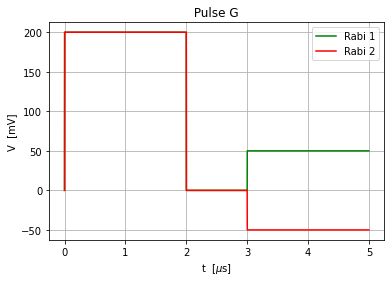

In [68]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(ti,pl,'-g',label= 'Rabi 1')
plt.plot(mti,mpl,'-r',label= 'Rabi 2')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [$\mu$s]')
ax.set_title(' Pulse G ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [42]:
PScheme2

[{'Name': 'Rabi2',
  'Amplitude': -200,
  'Start time': 1e-10,
  'End time': 2e-10,
  'Start Duration': 2,
  'End Duration': 6,
  'Sweep time': 0,
  'Sweep Duration': 0},
 {'Name': 'PulsoH',
  'Amplitude': -50,
  'Start time': 3,
  'End time': 20,
  'Start Duration': 1,
  'End Duration': 9,
  'Sweep time': 1,
  'Sweep Duration': 0}]

In [7]:
M8190A.write('TRAC:DWID WPR')

14

In [25]:
M8190A.write('TRAC1:DEL:ALL') #Delets the stored segments in the instrument

14

In [26]:
#Segment for Rabi1
M8190A.write('TRAC1:IQIM 1, "C:\\Users\\a.hernandez.de.la.ve\\Documents\\GitHub\\STM\\M8190\\SegmentA_625000.csv", CSV, BOTH, ON, ALEN')
M8190A.write('TRAC1:NAME 1, "Positive Probe"')

31

In [27]:
#Segment for Rabi2
M8190A.write('TRAC1:IQIM 2, "C:\\Users\\a.hernandez.de.la.ve\\Documents\\GitHub\\STM\\M8190\\SegmentB_625000.csv", CSV, BOTH, ON, ALEN')
M8190A.write('TRAC1:NAME 2, "Negative Probe"')

31

In [28]:
M8190A.query('TRAC1:CAT?') #catalogue of the corresponding traces stored in memory

'1,3750000,2,3750000'

In [12]:
M8190A.write(':TRAC1:SEL 2') 
M8190A.write('INIT:IMM')

9

In [148]:
M8190A.write('ABOR')

5

## Initializing the sequences

In [29]:
M8190A.write('SEQ1:DEL:ALL')

13

In [30]:
M8190A.write('FUNC1:MODE STS') 
M8190A.query('SEQ1:DEF:NEW? 2') #Defining the length (numbrer of table steps) of the Sequence
M8190A.query('SEQ:CAT?')

'0,2'

In [25]:
M8190A.query('SEQ:CAT?')

'0,2'

In [ ]:
### Understanding the structure of the SEQ:DATA command

#M8190A.write('[:SOURce]:SEQuence[1|2]:DATA <sequence_id>, <step> ,[<value>,<value>,…|<data block>] <segment_id>, <loop_count>,<advance_mode>,<marker_enable>, <start_addr>,<end_addr>

#M8190A.query('[:SOURce]:SEQuence[1|2]:DATA? <sequence_id>,<step>,<length>')

In [31]:
#This! Loading Segment 1 to step 0 of Sequence 0
M8190A.write('SEQ1:DATA 0,0,1,1,0,1,0,#hFFFFFFFF')

35

In [32]:
#Loading Segment 2 to step 1 of Sequence 0
M8190A.write('SEQ1:DATA 0,1,2,1,0,1,0,#hFFFFFFFF')

35

In [33]:
#The query form returns for a given sequence-id and step the segment data items (segment-id, loop-count, advance-mode, marker-enable, start-addr, end-addr).
#Getting this from the sequence generated via software

M8190A.query('SEQ1:DATA? 0,0,2')

'1,1,0,1,0,3749999,2,1,0,1,0,3749999'

In [34]:
M8190A.query('SYST:ERR?')

'0,"No error"'

In [37]:
M8190A.write('STAB1:SEQ:SEL 0')
M8190A.write('INIT:IMM')

9

In [38]:
M8190A.write('ABOR')

5

In [36]:
M8190A.query('FREQ:RAST?')

'1.25000000000000E+08'

In [35]:
M8190A.write('FREQ:RAST 125000000')

20

In [102]:
5e-3*6500000000

32500000.0

Sampling frecuency has some effect with the segmentation for the sequences, changing it from 125Mhz to 1Ghz made it so 6 repetitions of the segments transform into 3. Still have to play with this.

tomorrow: do a run with the 7.2 GHz sample rate and see if I get individual segments per sequences, as desired

In [34]:
M8190A.query('ROSC:SOUR:CHEC? INT')

'1'

In [40]:
M8190A.query('STAT:QUES:SEQ?')

'0'

### Animation

In [22]:
%matplotlib notebook
plt.style.use('seaborn-pastel')
fig = plt.figure()
ax = plt.axes(xlim=(-1, 32), ylim=(0, 11))
ax.grid(True)
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
line, = ax.plot([], [], color='black')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  We iterate over p and define the stopping point by the end value of frames in the anim function
def animate(i):
    y, time = Sweep(Pulses_List,100,i,32,1000)
    line.set_data(time, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=np.linspace(0,100), interval=400, blit=True)
plt.show()

#in our case, frames should match to the total number of time steps P

<IPython.core.display.Javascript object>

## To Do:
1. Code a "Rescale voltage program" to the obtain the dserided pulse amplitude by the given voltage output of the instrument. $\checkmark$
2. Calculate the  $\Delta \tau$ and study it's relation with the sample size and sampling rate, code this relation so we can get this parameters by any given  $\Delta \tau$. Partly $\checkmark$
3. Rewrite the code, adding a dictionary for the settings of the instrument, the renormalization of the Voltage $\checkmark$ and putting the pulse function in terms of $\Delta \tau$ and t $\checkmark$
4. Implement basic sequences, then implement the intended sequence of the future experiment

In [72]:
def Param(t,Δt):

    """This function gives the sample size N and the sampling rate Sr to be used for proper 
        pulse time scale.
        
        This function takes the desired total pulse time length and the desired time resolution
        and outputs the corresponding Sapmle size N to be used in the Sweeping function and it 
        also gives the Sample rate Sr to be set in the AWG, in order to get the proper
        time scale within the Pulse from the AWG. Everything should be in the correct units
    """
    #for the sampling rate we have 
    sr=(Δt)**-1

    #for the sample size N
    N=t*sr 

    return N,sr


In [74]:
Param(15e-6,_)

(108000.0, 7200000000.0)

# Misc. SCPI commands

In [ ]:
M8190A.query('SEQ:FREE?')

In [ ]:
M8190A.query('FUNC1:MODE?')

In [110]:
M8190A.query('MMEM:CAT?')

'117502717952,381959192576,"desktop.ini,,402","M8190A Queries.xlsx,,9966","[Custom Office Templates],,","[GitHub],,","[Keysight],,","[My Music],,","[My Pictures],,","[My Videos],,","[Notebooks],,","[Python Scripts],,","[Remote Assistance Logs],,"'

In [109]:
M8190A.query('SYST:SET?')

'#45950<setting type="setup"><pin name="CHANNEL 1"><attribute name="ArmMode" value="0" /><attribute name="CarrierFrequencyFractional" value="0" /><attribute name="CarrierFrequencyIntegral" value="2000000000" /><attribute name="CarrierPhaseOffset" value="0" /><attribute name="CarrierScale" value="1" /><attribute name="ChannelDelay" value="0" /><attribute name="ChannelDelayCoarse" value="0" /><attribute name="ChannelsCoupled" value="0" /><attribute name="ContinuousMode" value="1" /><attribute name="DisableHwDynamicSelect" value="0" /><attribute name="DisableHwEnable" value="0" /><attribute name="DisableHwEvent" value="0" /><attribute name="DisableHwTrigger" value="0" /><attribute name="DynamicSelect" value="0" /><attribute name="EnableMarker" value="1" /><attribute name="FunctionMode" value="1" /><attribute name="GatedMode" value="0" /><attribute name="OutputBalance" value="0" /><attribute name="OutputNormalState" value="1" /><attribute name="OutputRoute" value="1" /><attribute name="Red

In [87]:
M8190A.query('*OPC?') #this is for checking that the previous commands were completed

'1'

In [47]:
M8190A.write('*CLS')

5

In [22]:
M8190A.write('*RST') #Reseting the instrument to factory settings

5

In [98]:
M8190A.write('TRAC1:DEL:ALL') #Delets the stored segments in the instrument

14

In [133]:
M8190A.write('ABOR') #self explanatory

5

Sequences are visualized in Tables, each table entry corresponds to a segment.

Users Manaual page 251:

_"Sequences are made of a number of arbitrary waveforms, which can be linked and looped in user-programmable order. Sequences are generated from waveforms stored in the waveform memory as memory segments."_

A segment corresponds to a waveform (just one?), i.e. some sample data with a corresponding sampling rate frecuency.

:TRAC subsystem to generate segments ($\checkmark$)

:SEQ subsystem to generate sequences.

Trigger for seq A and advance for seq b ??

Internal Trigger Generator

reference oscillator


usual data loaded, internal frecuency set at 15 kHz, sequence is repeted after a time interval of roughly 52us, below this internal frecuency, there is only one sequence displayed.

Advancent/ event triggering due to internal clock related to marker syncronization?

In [42]:
M8190A.query('OUTP:ROUT?')

'DC'

# Pulse Segments for different $\Delta\tau$

In [2]:
start = time.time()


obo,ti = Tau(Pulses_List,5,10,625000)


end = time.time()

print(end - start)

31.39645481109619


In [10]:
len(obo)

6

In [10]:
DFA3 = CSV_PD(obo[0],'A','prob')
DFA4 = CSV_PD(obo[1],'A','prob')
DFA5 = CSV_PD(obo[2],'A','prob')

In [11]:
DFAS= [DFA3, DFA4, DFA5]

In [14]:
DFAS[2]

,Y1,SyncMarker1,SampleMarker1
0,0.0,1,1
1,200.0,1,1
2,200.0,1,1
3,200.0,1,1
4,200.0,1,1
...,...,...,...
624995,0.0,1,1
624996,0.0,1,1
624997,0.0,1,1
624998,0.0,1,1


In [21]:
DFASS=[]
for x in obo:
    for i in range(len(obo)):
        DFASS[i] = CSV_PD(x,'A','SegmentA_625000_{itr}'.format(itr = i)

               


SyntaxError: unexpected EOF while parsing (<ipython-input-21-de06f4a0c753>, line 6)

In [30]:
range(len(obo))

range(0, 6)

In [36]:
DFASS= []
for i in range(len(obo)):
       DFASS.append(i) 

In [37]:
DFASS

[0, 1, 2, 3, 4, 5]

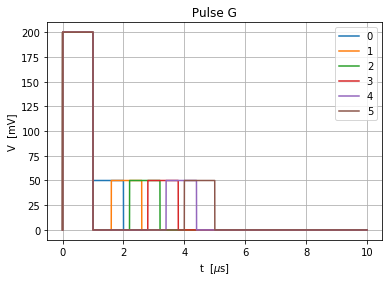

In [3]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(ti,obo[0],label= '0')
plt.plot(ti,obo[1],label= '1')
plt.plot(ti,obo[2],label= '2')
plt.plot(ti,obo[3],label= '3')
plt.plot(ti,obo[4],label= '4')
plt.plot(ti,obo[5],label= '5')
#plt.plot(mti,mpl,'-r',label= 'Rabi 2')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [$\mu$s]')
ax.set_title(' Pulse G ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')